<ipython-input-5-aa36d5128720>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-5-aa36d5128720>:580: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  csxv=np.zeros((moire_BZ.Np,levels,levels),dtype=np.complex)
No artists with labels fo

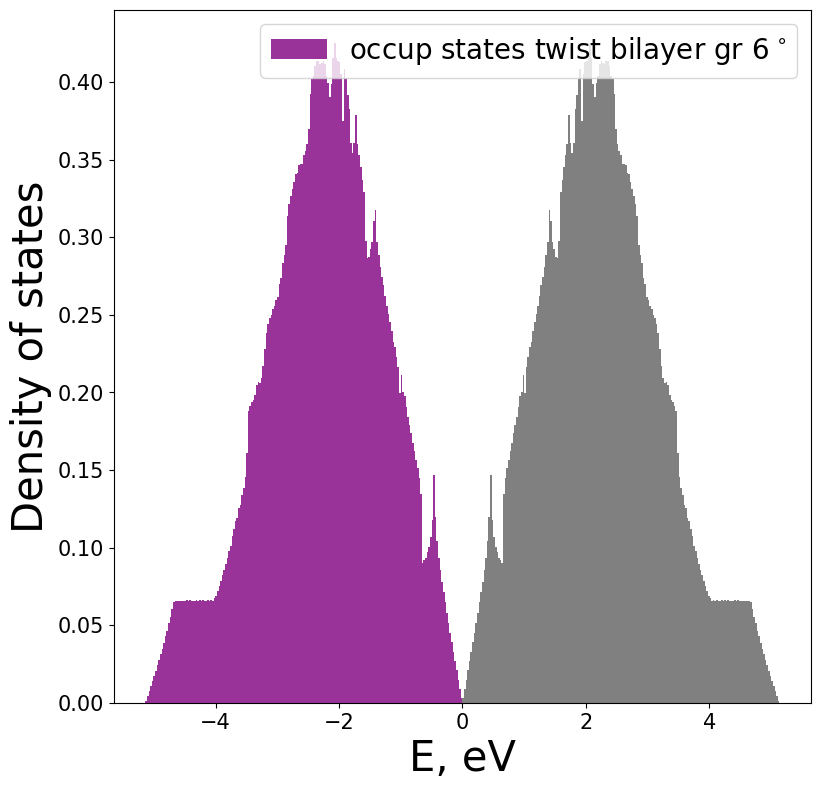

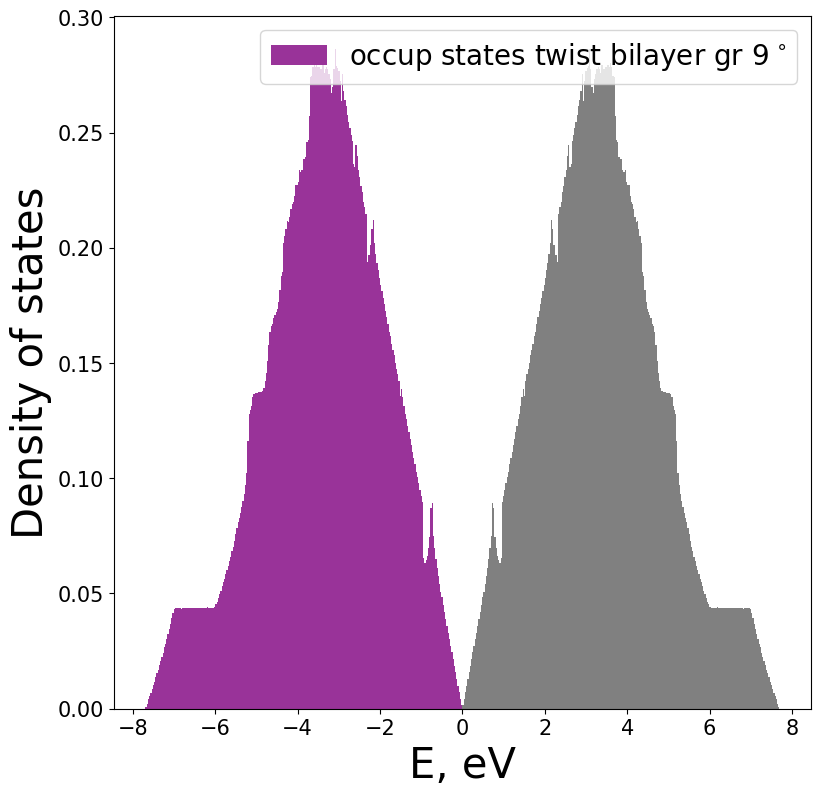

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cmath
import seaborn as sns
from scipy.linalg import block_diag
plt.style.use("seaborn")

import mdirac as md

### twisted bilayer graphene constants
gamma = 3 # hopping parameter in graphene
t = 2*np.pi*np.sqrt(3)/2*gamma # effective multiplier before dimensionless k*sigma in hamiltonian
#t0 = 0.4 # eV
t_layers = 0.11 # eV
u1 = 0.0761 # eV
u2 = 0.1031 # eV
dims = [6,6,6,4,4,4,2,2,2,2,2]
ksteps = [0.0002,0.0002,0.0002,0.0003,0.0003,0.0003,0.0005,0.0005,0.0005,0.0005]

deg = 4 # spin+valley degeneracy
for angle in np.arange(6,10,3):
    
    angle = int(angle)
    theta = angle*np.pi/180
    a = 0.246 # nm
    d0 = 0.335 # nm

    # bilayer graphene tight-binding model parameters (Moon Koshino 2013)
    a0 = a/np.sqrt(3)
    Vppsigma = 0.48  # eV
    Vpppi = -2.7  # eV
    delta0 = 0.184 * a  # nm
    h0 = 0.3349  # nm
    rc = 0.614  # nm
    lc = 0.0265  # nm

    ###

    ### grid settings. scale
    kstep0 = ksteps[angle]
    #scale=0.4
    cell=kstep0*np.array([[0.5,0.5*np.sqrt(3)],[0.5,-0.5*np.sqrt(3)]])
    q1 = np.array([0.5,0.5*np.sqrt(3)])
    q2 = np.array([0.5,-0.5*np.sqrt(3)])
    N = int(2/kstep0)
    dim = dims[angle] # parameter which controls number of folded moire brilloiun zones in hamiltonian
    # dim is even, hamiltonian dimensionality will be 2*(dim+1)**2 *2 rows (2 layers, (dim+1)**2 hexs, 2 sublattices)
    kmesh = md.mesh.Parallelogram(N,cell)
    #circle = kmesh.get_MBZ(scale=scale)
    ###

    ### system settings
    def mkdir_p(mypath):
        from errno import EEXIST
        try:
            os.makedirs(mypath)
        except OSError as exc:
            if exc.errno == EEXIST and os.path.isdir(mypath):
                pass
            else: raise
    path = 'out/tbg_newnewnew/gamma'+str(gamma)+'kstep0'+str(kstep0)+'tl'+str(t_layers)+'nn'+'angle'+str(angle)+'_dim'+str(dim)+'corr'
    mkdir_p(path)
    ###

    ### Fourier amplitudes analysis (optional, enough to execute one time)

    def NeededSites(theta, M):
        # describes what N should be taken to have at least M moire patterns on the grid

        return 0.5 * (np.sqrt(M) / (2 * np.sin(theta / 2)) - 1)

    M = 8
    N1 = int(NeededSites(theta, M))  # N lat_vec to each side from the origin
    #N1 = 10
    N1ext = int(1.5*N1)
    inds = np.arange(-N1,N1,1)
    inds_ext = np.arange(-N1ext,N1ext,1)
    #Next = int(1.5*NeededSites(theta, M))
    # 1.5 is the correction to avoid atoms without interlayer neighbours in (-N,N) ranges

    def Rotation(theta):
        c, s = np.cos(theta), np.sin(theta)
        return np.array(((c, -s), (s, c)))

    a1 = a*np.array([0.5*np.sqrt(3),0.5])
    a2 = a*np.array([0.5*np.sqrt(3),-0.5])
    lat_vec_bottom1 = np.matmul(Rotation(-theta/2), a1)
    lat_vec_bottom2 = np.matmul(Rotation(-theta/2), a2)
    a1M = 1/(2*np.sin(0.5*theta))*np.matmul(Rotation(np.pi/2), lat_vec_bottom1)
    a2M = 1/(2*np.sin(0.5*theta))*np.matmul(Rotation(np.pi/2), lat_vec_bottom2)
    lat_vec_top1 = np.matmul(Rotation(theta/2), a1)
    lat_vec_top2 = np.matmul(Rotation(theta/2), a2)

    tau_bottom = a/np.sqrt(3)*np.matmul(Rotation(-theta/2),np.array([1,0]))
    tau_top = a/np.sqrt(3)*np.matmul(Rotation(theta/2),np.array([1,0]))

    def DistBottomTop(bottom_atom, sublattice_bottom, top_atom, sublattice_top):
        # bottom_atom and top_atom are indices [i,j] and [n,k] of lattice elements
        # sublattice =0 stands for A, =1 stands for B
        # returns distance between given atoms
        shift_bottom = 0.5*(2*sublattice_bottom-1)*tau_bottom
        shift_top = 0.5*(2*sublattice_top-1)*tau_top
        vec_bottom_atom = bottom_atom[0] * lat_vec_bottom1 + bottom_atom[1] * lat_vec_bottom2 + shift_bottom
        vec_top_atom = top_atom[0] * lat_vec_top1 + top_atom[1] * lat_vec_top2 + shift_top
        return np.sqrt(np.linalg.norm(vec_top_atom - vec_bottom_atom)**2 + d0**2)


    # print(DistBottomTop([0,0],1,[0,5],1))

    def ExtractFirsts(lst):
        return [item[0] for item in lst]


    def ClosestAtomFromTop(bottom_atom, sublattice_bottom, sublattice_top):
        # finds [n,k] of atom from top layer within given sublattice
        # which is the closest to given [i,j] atom from sublattice_bottom from the bottom
        # returns distance to closest atom, its coordinates and vector in plane which connects bottom atom to top atom

        shift_bottom = 0.5*(2*sublattice_bottom-1)*tau_bottom
        vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1 + bottom_atom[1]*lat_vec_bottom2 + shift_bottom
        dists = []
        for n in inds_ext:
            for k in inds_ext:
                dists.append([DistBottomTop(bottom_atom, sublattice_bottom,
                                            [n,k], sublattice_top), [n, k]])
        distances = ExtractFirsts(dists)
        index = np.argmin(np.array(distances))
        shift_top = 0.5*(2*sublattice_top-1)*tau_top
        vec_top_atom = dists[index][1][0] * lat_vec_top1 + dists[index][1][1] * lat_vec_top2 + shift_top
        delta = vec_top_atom - vec_bottom_atom
        return [dists[index], delta]

    def ClosestAtomFromTopAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top):
        # (!) bottom atoms must be indexed without gaps to always find relevant aim atoms. it requires 'snake' indexing
        # finds [n,k] of atom from top layer within given sublattice_top
        # which is the closest to given [i,j] atom from sublattice_bottom from the bottom
        # returns distance to closest atom, its coordinates and vector in plane which connects bottom atom to top atom

        window = 4
        shift_bottom = 0.5*(2*sublattice_bottom-1)*tau_bottom
        vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1+bottom_atom[1]*lat_vec_bottom2 + shift_bottom
        dists = []
        for n in range(aim_atom[0]-window, aim_atom[0]+window):
            for k in range(aim_atom[1]-window, aim_atom[1]+window):
                dists.append([DistBottomTop(bottom_atom, sublattice_bottom,
                                            [n,k], sublattice_top), [n, k]])
        distances = ExtractFirsts(dists)
        index = np.argmin(np.array(distances))
        shift_top = 0.5*(2*sublattice_top-1)*tau_top
        vec_top_atom = dists[index][1][0]*lat_vec_top1+dists[index][1][1]*lat_vec_top2 + shift_top
        delta = vec_top_atom-vec_bottom_atom
        return [dists[index],delta]


    # print(ClosestAtomFromTop([4,2],0,0))

    def ClosestAtomFromTopPlotter(N1):
        #N = int(0.5*N)
        mindist = np.ones((2*N1,2*N1)) # initially greater then any reasonable interatomic distance in nm
        ab = [[0,0],[0,1],[1,0],[1,1]]
        flag = 0
        sign = 1
        for a,b in ab:
            for n in inds:
                for k in inds:
                    if flag==0:
                        if mindist[n+N1,k+N1]>ClosestAtomFromTop([n,k],a,b)[0][0]:
                            mindist[n+N1,k+N1] = ClosestAtomFromTop([n,k],a,b)[0][0]
                        aim_atom = ClosestAtomFromTop([n,k],a,b)[0][1]
                        flag = 1
                    else:
                        # k signed (or k snake) provides gapless transition from index to index
                        ks = k*sign-1*(sign<0)
                        if mindist[n+N1,ks+N1]>ClosestAtomFromTopAimed(aim_atom,[n,ks],a,b)[0][0]:
                            mindist[n+N1,ks+N1] = ClosestAtomFromTopAimed(aim_atom,[n,ks],a,b)[0][0]
                        aim_atom = ClosestAtomFromTopAimed(aim_atom,[n,ks],a,b)[0][1]
                sign = sign*(-1)
            flag = 0
            sign = 1

        gridi = np.arange(0,2*N1)
        gridj = np.arange(0,2*N1)
        iv,jv = np.meshgrid(gridi,gridj,indexing='ij')
        hexiv = iv*lat_vec_bottom1[0]+jv*lat_vec_bottom2[0]
        hexjv = iv*lat_vec_bottom1[1]+jv*lat_vec_bottom2[1]

        fig, ax = plt.subplots(figsize=(9,9))
        plt.title('Moire structure, angle = '+str(angle)+' degrees', fontsize=15)
        ax.contourf(hexiv,hexjv,np.abs(mindist),cmap='Pastel1')
        ax.set_xlabel('x coordinate, nm', fontsize=20)
        ax.set_ylabel('y coordinate, nm', fontsize=20)

        x0 = N1*(lat_vec_bottom1[0]+lat_vec_bottom2[0])
        y0 = N1*(lat_vec_bottom1[1]+lat_vec_bottom2[1])
        ax.set_aspect('equal', adjustable='box')
        plt.arrow(x0,y0,a1M[0],a1M[1],lw=5,color='g',head_width=0.7, head_length=0.3,
                  label='Moire lattice vectors')
        plt.arrow(x0,y0,a2M[0],a2M[1],lw=5,color='g',head_width=0.7, head_length=0.3)
        plt.scatter(hexiv,hexjv,color='blue',alpha=0.5,s=4.5,
                    label='lattice sites')
        plt.legend()
        save_to = path+'/ClosestAtomFromTop'+str(angle)+'.png'
        plt.savefig(save_to,dpi=180)

    #ClosestAtomFromTopPlotter(N1)


    def Hopping(vec, sublattice_bottom, sublattice_top):
        # vec is a vector connecting atoms from bottom and top layer in 2D (top minus bottom)
        # returns value -t(d) following Moon Koshino (2013)
        # if delta knows about sublattices indices (output from ClosestAtomFromTop) -> 0,0 in this formula

        # next line should be modified if sublattice indices are needed in this function. in this script 0,0 put here
        # because output 'vec' from ClosestAtomFromTop already accounts for sublattice index
        #vec = vec + (sublattice_top - sublattice_bottom) * tau
        full_dist = np.sqrt(np.linalg.norm(vec) ** 2 + d0 ** 2)
        Vpi = Vpppi * np.exp(-(full_dist - a0) / delta0)
        Vsigma = Vppsigma * np.exp(-(full_dist - d0) / delta0)
        return Vpi * (1 - (d0 / full_dist) ** 2) + Vsigma * (d0 / full_dist) ** 2


    # Hopping([-0,0],0,0)

    ### Defining Moire elementary cell vectors
    ### BZ -> MBZ with two operations 1) *2sin(theta/2) 2) rotate counterclockwise pi/2

    G1Mcell = np.matmul(Rotation(np.pi/2),q1)
    G1M = 8*np.pi/(np.sqrt(3)*a)*np.sin(0.5*theta)*G1Mcell
    G2Mcell = np.matmul(Rotation(np.pi/2),q2)
    G2M = 8*np.pi/(np.sqrt(3)*a)*np.sin(0.5*theta)*G2Mcell

    # always choose bottom Dirac point for certainty
    K = 2*np.pi/a*np.array([0, -2/3])

    def HamiltForK(bottom_atom, sublattice_bottom, sublattice_top):
        # bottom atom is an array [i,j]
        # tight-binding model with hoppings to 9 closest neighbours
        # returns value of hamiltonian matrix element between bloch states
        # with given wave number K from Dirac point

        top_atom = ClosestAtomFromTop(bottom_atom, sublattice_bottom, sublattice_top)
        delta = top_atom[1]
        ham = 0
        for i in np.arange(-1, 2):
            for j in np.arange(-1, 2):
                # go through 9 nearest neighbours from top
                vec = delta + i * lat_vec_top1 + j * lat_vec_top2
                phase = -np.dot(K, vec)
                ham += Hopping(vec,0,0)*np.exp(1.j*phase)  
                # delta knows about sublattices indices hence 0,0 in this formula
        return [ham, top_atom]

    def HamiltForKAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top):

        # bottom atom is an array [i,j]
        # tight-binding model with hoppings to 9 closest neighbours
        # returns value of hamiltonian matrix element between bloch states
        # with given wave number K from Dirac point

        top_atom = ClosestAtomFromTopAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top)
        delta = top_atom[1]
        ham = 0
        for i in np.arange(-1,2):
            for j in np.arange(-1,2):
                # go through 9 nearest neighbours from top
                vec = delta + i*lat_vec_top1 + j*lat_vec_top2
                phase = -np.dot(K, vec)
                ham += Hopping(vec,0,0)*np.exp(1.j*phase) 
                # delta knows about sublattices indices hence 0,0 in this formula
        return [ham, top_atom]

    # HamiltForK([0,5],0,0)

    def FourierHopping(moire_vec, sublattice_bottom, sublattice_top):
        # moire vec is described by list [n,k] and equals n*G1M+k*G2M
        # returns fourier amplitude of hopping function

        ampl = 0
        flag = 0
        sign = 1

        for n in inds:
            for k in inds:
                if flag==0:
                    shift_bottom = 0.5*(2*sublattice_bottom-1)*tau_bottom
                    vec_bottom_atom = n*lat_vec_bottom1 + k*lat_vec_bottom2 + shift_bottom
                    hamiltonian = HamiltForK([n, k], sublattice_bottom, sublattice_top)
                    hopping = hamiltonian[0]
                    top_atom = hamiltonian[1]
                    aim_atom = top_atom[0][1]
                    delta = top_atom[1]
                    G = moire_vec[0]*G1M + moire_vec[1]*G2M
                    phase = -np.dot(G, vec_bottom_atom)  # phase before K*delta + of 0
                    ampl += hopping * np.exp(1.j*phase)
                    flag = 1
                else:
                    ks = k*sign-1*(sign<0)
                    shift_bottom = 0.5*(2*sublattice_bottom-1)*tau_bottom
                    vec_bottom_atom = n*lat_vec_bottom1+ks*lat_vec_bottom2 + shift_bottom
                    hamiltonian = HamiltForKAimed(aim_atom, [n,ks], sublattice_bottom, sublattice_top)
                    hopping = hamiltonian[0]
                    top_atom = hamiltonian[1]
                    aim_atom = top_atom[0][1]
                    G = moire_vec[0]*G1M + moire_vec[1]*G2M
                    phase = -np.dot(G, vec_bottom_atom)
                    ampl += hopping*np.exp(1.j*phase)
            sign = sign*(-1)

        return ampl/(2*N1)**2


    def FourierHeatMap():
        FourierAmpls = np.zeros((5,5))

        for i in np.arange(-2,3):
            for j in np.arange(-2,3):
                FourierAmpls[i+2,j+2] = np.abs(FourierHopping([i,j],0,0))
        xs = np.flip(np.arange(-2,3)).tolist()
        ys = np.arange(-2,3).tolist()
        plt.figure(figsize=(10,10))
        heat_map = sns.heatmap(FourierAmpls, linewidth = 1 ,
                               annot = True, cmap="Blues", fmt = ".3g",
                              xticklabels=xs, yticklabels=ys)
        plt.title( "lattice sites = " + str((2*N1)**2) + ", angle = " + str(angle),fontsize=15)
        save_to = path+'/heatmap'+str(angle)+'.png'
        #plt.show()
        plt.savefig(save_to,dpi=180)

    #FourierHeatMap()
    # for default lattice vectors dominant amplitudes will be for 00, 01, 10

    ### check complex matrices for dominant scattering processes

    def FourierComplexAmpl(n,m, alpha, beta):
        ampl = FourierHopping([n,m],alpha,beta)
        p = cmath.phase(ampl)
        t = np.abs(ampl)
        phi = 2*np.pi/3
        print("t = ", t, "phase = ",p)

    """"
    ab = [[0,0],[0,1],[1,0],[1,1]]
    sc = [[0,0],[0,1],[-1,0]]
    scat = np.zeros((3,2,2,2))

    for i in range(3):
        for a,b in ab:
            scat_ind = sc[i]
            ampl = FourierHopping(scat_ind,a,b)
            p = cmath.phase(ampl)*180/np.pi
            t = np.abs(ampl)
            scat[i,a,b] = np.array([t,p])
    """

    #scat[0,:,:,0] -> 0.1 eV
    #scat[0,:,:,1] -> [[0,0],[0,0]]
    #scat[1,:,:,0] -> 0.1 eV
    #scat[1,:,:,1] -> [[0,-120],[120,0]]
    #scat[2,:,:,0] -> 0.1 eV
    #scat[2,:,:,1] -> [[0,120],[-120,0]]


    ### defining hamiltonian 
    ### Moire Brilloin zone centered in the middle between rotated K1, K2
    ### all wavevectors in units of 2pi/a

    G1M = 4/np.sqrt(3)*np.sin(0.5*theta)*G1Mcell
    G2M = 4/np.sqrt(3)*np.sin(0.5*theta)*G2Mcell

    k0 = 4/3*np.sin(0.5*theta) # distance between K1 and K2 in MBZ; one side of its hexagon

    K1 = k0*np.array([-0.5,0])
    K2 = k0*np.array([0.5,0])
    Kl = [K1,K2] # to access it by number of layer
    inds_dim = np.arange(-dim//2,dim//2+1) 
    dim_H = 4*(dim+1)**2

    moire_BZ = kmesh.get_MoireBZ(scale=k0)

    ### unrelaxed scattering matrices
    phase = 2/3*np.pi
    plus00 = np.array([[u1,u2],[u2,u1]])
    plus01 = np.array([[u1,u2*np.exp(-1.j*phase)],[u2*np.exp(1.j*phase),u1]])
    plusm10 = np.array([[u1,u2*np.exp(1.j*phase)],[u2*np.exp(-1.j*phase),u1]])

    def FoldK(i,j,l,ind):
        """
        input: i,j so that i*G1M+j*G2M will be considered
        l is index of layer: 0, 1 -> bottom, top
        ind is 0,1 accounts for x,y coordinate
        """
        return i*G1M[ind]+j*G2M[ind]-Kl[l][ind]

    def TwistHamiltonian(kx,ky,angle,dim,t,t_layers):
        """
        input: kx,ky from 1st moire brilloine zone
        dim controls the dimensionality -> 2*(dim+1)*2 rows
        t, t_layers intralayer and interlayer hoppings in eV -> 3.0, 0.11 (can be tuned)
        """
        list_mono1 = [[[0,1.j*(kx+FoldK(i,j,0,0))-(ky+FoldK(i,j,0,1))],
                       [-1.j*(kx+FoldK(i,j,0,0))-(ky+FoldK(i,j,0,1)),0]] 
                      for i in inds_dim for j in inds_dim]
        list_mono2 = [[[0,1.j*(kx+FoldK(i,j,1,0))-(ky+FoldK(i,j,1,1))],
                       [-1.j*(kx+FoldK(i,j,1,0))-(ky+FoldK(i,j,1,1)),0]] 
                      for i in inds_dim for j in inds_dim]

        ham_mono1 = block_diag(*list_mono1)
        ham_mono2 = block_diag(*list_mono2)
        ### [0,0] scattering blocks
        keys00 = np.identity((dim+1)**2)
        scat00 = np.kron(keys00, plus00)
        ### [0,1] scattering blocks. 1 step down corresponds to +G2M scattering process
        keys01 = np.diag(np.ones((dim+1)**2-1),1)
        scat01 = np.kron(keys01, plus01)
        ### [-1,0] scattering blocks. dim+1 steps up corresponds to -G1M scattering process
        keysm10 = np.diag(np.ones((dim+1)**2-(dim+1)),dim+1)
        scatm10 = np.kron(keysm10,plusm10)

        scat = scat00 + scat01 + scatm10
        ham = np.block([[t*ham_mono1, np.conj(scat)],[scat, t*ham_mono2]])
        return ham

    ### dispersion curves plotting
    Nst = k0
    stepsGK = int(Nst/kstep0)
    stepsKM = int(1/2*Nst/kstep0)
    stepsMG = int(np.sqrt(3)/2*Nst/kstep0)

    kGKx = -0.5*kstep0
    kGKy = -0.5*np.sqrt(3)*kstep0
    kKMx = -0.5*kstep0
    kKMy = 0.5*np.sqrt(3)*kstep0
    kMGx = 0.5*np.sqrt(3)*kstep0
    kMGy = 0.5*kstep0

    kx = 0
    ky = 0

    AllK = stepsGK+stepsKM+stepsMG
    disp = np.zeros((AllK,dim_H),float)

    for i in np.arange(stepsGK):
        kx += kGKx
        ky += kGKy
        ham = TwistHamiltonian(kx,ky,angle,dim,t,t_layers)
        eigenvalues = np.linalg.eigvalsh(ham)
        disp[i] = np.real(eigenvalues)

    for i in np.arange(stepsGK,stepsGK+stepsKM):
        kx += kKMx
        ky += kKMy
        ham = TwistHamiltonian(kx,ky,angle,dim,t,t_layers)
        eigenvalues = np.linalg.eigvalsh(ham)
        disp[i] = np.real(eigenvalues)

    for i in np.arange(stepsGK+stepsKM,stepsGK+stepsKM+stepsMG):
        kx += kMGx
        ky += kMGy
        ham = TwistHamiltonian(kx,ky,angle,dim,t,t_layers)
        eigenvalues = np.linalg.eigvalsh(ham)
        disp[i] = np.real(eigenvalues)

    plt.style.use("default")

    fig, ax = plt.subplots(figsize=(9,9))

    bands=15//angle+4
    for j in range(dim_H//2-bands,dim_H//2+bands,1):
        plt.plot(np.arange(AllK), disp[:,j], linestyle="-", linewidth=5,
                 label=(j==dim_H//2)*('twisted bilayer graphene, angle '+str(angle)+r'$\:^{\circ}$'))

    ax.set_ylabel('E, eV', fontsize=30)
    plt.ylim(-1.8,2.1)
    ax.set_facecolor('white')
    plt.xticks(np.array([0,stepsGK,stepsGK+stepsKM,stepsGK+stepsKM+stepsMG]),
               [r'$\overline{\Gamma}$',r'$\overline{K}$',r'$\overline{M}$',r'$\overline{\Gamma}$'], fontsize=40)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.savefig(path+'/GKMG.png',dpi=180)
    plt.close()

    stepsK1G = int(1/2*Nst/kstep0)
    stepsGM = int(np.sqrt(3)/2*Nst/kstep0)
    stepsMK2 = int(Nst/kstep0)

    kK1Gx = 1*kstep0
    kK1Gy = 0
    kGMx = 0
    kGMy = -1*kstep0
    kMK2x = 0.5*kstep0
    kMK2y = 0.5*np.sqrt(3)*kstep0

    kx = -0.5*k0
    ky = 0

    AllK = stepsGK+stepsKM+stepsMG
    disp = np.zeros((AllK,dim_H),float)

    for i in np.arange(stepsK1G):
        kx += kK1Gx
        ky += kK1Gy
        ham = TwistHamiltonian(kx,ky,angle,dim,t,t_layers)
        eigenvalues = np.linalg.eigvalsh(ham)
        disp[i] = np.real(eigenvalues)

    for i in np.arange(stepsK1G,stepsK1G+stepsGM):
        kx += kGMx
        ky += kGMy
        ham = TwistHamiltonian(kx,ky,angle,dim,t,t_layers)
        eigenvalues = np.linalg.eigvalsh(ham)
        disp[i] = np.real(eigenvalues)

    for i in np.arange(stepsK1G+stepsGM,stepsK1G+stepsGM+stepsMK2):
        kx += kMK2x
        ky += kMK2y
        ham = TwistHamiltonian(kx,ky,angle,dim,t,t_layers)
        eigenvalues = np.linalg.eigvalsh(ham)
        disp[i] = np.real(eigenvalues)

    fig, ax = plt.subplots(figsize=(9,9))

    for j in range(dim_H//2-bands,dim_H//2+bands,1):
        plt.plot(np.arange(AllK), disp[:,j], linestyle="-", linewidth=5,
                 label=(j==dim_H//2)*('twisted bilayer graphene, angle '+str(angle)+r'$\:^{\circ}$'))

    ax.set_ylabel('E, eV', fontsize=30)
    plt.ylim(-1.8,2.1)
    plt.yticks(fontsize=15)
    ax.set_facecolor('white')
    plt.legend(loc='upper right', fontsize=20)
    plt.xticks(np.array([0,stepsK1G,stepsK1G+stepsGM,stepsK1G+stepsGM+stepsMK2]),
               [r'$K_1$',r'$\overline{\Gamma}$',r'$\overline{M}$',r'$K_2$'], fontsize=40)
    plt.tight_layout()
    plt.savefig(path+'/K1GMK2.png',dpi=180)
    plt.close()
    

    ### eigensystem writing
    timelog = open(path+"/timelog.txt", "w")
    startTime = time.time()
    E=np.zeros((moire_BZ.Np,dim_H),dtype=np.float64)
    U=np.zeros((moire_BZ.Np,dim_H,dim_H),dtype=np.complex128)
    for i,pi in enumerate(moire_BZ.p):
        ham = TwistHamiltonian(pi[0],pi[1],angle,dim,t,t_layers)
        E[i],U[i]=np.linalg.eigh(ham)
    executionTime = (time.time() - startTime)
    timelog.write("Hamiltonian diagonalization time: " + str(executionTime) + '\n')
    timelog.close()

    ### DoS plotting
    fig, ax = plt.subplots(figsize=(9,9))
    ax.set_xlabel('E, eV', fontsize=30)
    ax.set_ylabel('Density of states', fontsize=30)
    ax.legend(loc='upper right')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    val_ens = np.ravel(np.array([E[:,i] for i in np.arange(dim_H//2)]))
    cond_ens = np.ravel(np.array([E[:,i] for i in np.arange(dim_H//2,dim_H,1)]))

    plt.hist(val_ens,bins='auto',density=True,color='#993399',
             label='occup states twist bilayer gr '+str(angle)+r'$\:^{\circ}$')
    plt.hist(cond_ens,bins='auto',density=True,color='#808080')

    plt.legend(fontsize=20)
    plt.savefig(path+'/dos.png',dpi=180)

    ### spectra writing parameters
    #### omega is in units of eV 
    bound = 3.5
    scaleomega = 3.5/1000
    omega=np.linspace(1.e-5,bound,1000) 
    eta=0.001
    factorsigma=-deg*kmesh.vcell*gamma**2*3/1.j 
    levels=dim_H//2
    edge_v = levels-1
    edge_c = levels
    csxv=np.zeros((moire_BZ.Np,levels,levels),dtype=np.complex)
    dE=np.zeros((moire_BZ.Np,levels,levels),dtype=np.float64)
    sigma0=np.zeros((omega.shape[0],levels,levels),dtype=np.complex128)
    ###

    ### calculation of spectra
    keys0 = np.identity(levels)
    sx=np.array([[0,1],[1,0]])
    Sx=np.kron(keys0,sx)

    for ind_v in np.arange(edge_v,edge_v-levels,-1):
        for ind_c in np.arange(edge_c,edge_c+levels,1):
            i = edge_v-ind_v
            j = ind_c - edge_c
            csxv[:,i,j] = md.cov_matrix_elements(Sx,U,ind_c,ind_v)
            dE[:,i,j] = E[:,ind_c]-E[:,ind_v]
            sigma0[:,i,j]=md.get_sigma_xx(factorsigma,omega+1.j*eta,dE[:,i,j],csxv[:,i,j])

    alph = 1/137
    lambd = 1240/omega # eV -> nm
    d = 2*0.335 # graphene thickness, nm
    eps = 1+1/2*alph*np.sum(sigma0,axis=(1,2))*lambd/d*1.j
    ###

    ### plotting results
    def SigmaPlotter(left_cut, right_cut,scaleomega,omega,sigma): 
        omegas = np.arange(omega.shape[0])[left_cut:right_cut]
        fig,ax=plt.subplots(figsize=(9,9))
        ax.plot(scaleomega*omegas,
                np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2))),
                c='y',label='twist gr '+str(angle)+r'$\:^{\circ}$',lw=5)
        ax.set_xlabel(r'$\omega$, eV',fontsize=15)
        ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
        ymin = min(np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2))))-0.3
        ymax = max(np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2))))+0.3
        ax.set_ylim([ymin,ymax])
        ax.legend(loc='upper right')
        fig.tight_layout()
        realsigmapath = path + '/realsigma'+str(left_cut)+'_'+str(right_cut)+'_angle'+str(angle)+'.png'
        sigmatofile = np.column_stack([omega[left_cut:right_cut], 
                                       np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2)))])
        np.savetxt(path+'/sigma'+'_angle'+str(angle)+'.txt',sigmatofile)
        plt.savefig(realsigmapath,dpi=180)
        plt.close()

    def OptConstsPlotter(left_cut, right_cut,scaleomega,omega,eps,epsinf): 
        omegas = np.arange(omega.shape[0])[left_cut:right_cut]
        refr = np.sqrt(eps+epsinf)[left_cut:right_cut]
        fig,ax=plt.subplots(figsize=(9,9))
        ax2 = ax.twinx()
        ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='model refr index twist gr '+str(angle)+r'$^{\circ}$')
        ax2.plot(scaleomega*omegas,refr.imag,c='g',label='model ext coeff twist gr'+str(angle)+r'$^{\circ}$')
        ax.legend(loc='upper left',fontsize=15)
        ax2.legend(loc='upper right',fontsize=15)
        ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
        ax.set_ylim([0,np.max(refr.real)+1])
        ax2.set_ylim([0,np.max(refr.imag)+1])
        ax.set_xlabel(r'$\omega$, eV',fontsize=15)
        ax.set_ylabel('Refractive index n',c='#6C09C9',fontsize=15)
        ax2.set_ylabel('Extinction coefficient k',c='g',fontsize=15)
        fig.tight_layout()
        optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
        plt.savefig(optconstspath)
        conststofile = np.column_stack([omega[left_cut:right_cut], refr.real, refr.imag])
        np.savetxt(path+'/optconsts.txt',conststofile)
        plt.close()

    OptConstsPlotter(100,1000,scaleomega,omega,eps,6.5)
    SigmaPlotter(100,1000,scaleomega,omega,sigma0)

    ###

In [5]:
angle=9
def SigmaPlotter(left_cut, right_cut,scaleomega,omega,sigma): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    fig,ax=plt.subplots(figsize=(9,9))
    ax.plot(scaleomega*omegas,
            np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2))),
            c='y',label='twist gr '+str(angle)+r'$\:^{\circ}$',lw=5)
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
    ymin = min(np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2))))-0.3
    ymax = max(np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2))))+0.3
    ax.set_ylim([ymin,ymax])
    ax.legend(loc='upper right')
    fig.tight_layout()
    realsigmapath = path + '/realsigma'+str(left_cut)+'_'+str(right_cut)+'_angle'+str(angle)+'.png'
    sigmatofile = np.column_stack([omega[left_cut:right_cut], 
                                   np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2)))])
    np.savetxt(path+'/sigma'+'_angle'+str(angle)+'.txt',sigmatofile)
    plt.savefig(realsigmapath,dpi=180)
    plt.close()

def OptConstsPlotter(left_cut, right_cut,scaleomega,omega,eps,epsinf): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    refr = np.sqrt(eps+epsinf)[left_cut:right_cut]
    fig,ax=plt.subplots(figsize=(9,9))
    ax2 = ax.twinx()
    ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='model refr index twist gr '+str(angle)+r'$^{\circ}$')
    ax2.plot(scaleomega*omegas,refr.imag,c='g',label='model ext coeff twist gr'+str(angle)+r'$^{\circ}$')
    ax.legend(loc='upper left',fontsize=15)
    ax2.legend(loc='upper right',fontsize=15)
    ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
    ax.set_ylim([0,np.max(refr.real)+1])
    ax2.set_ylim([0,np.max(refr.imag)+1])
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.set_ylabel('Refractive index n',c='#6C09C9',fontsize=15)
    ax2.set_ylabel('Extinction coefficient k',c='g',fontsize=15)
    fig.tight_layout()
    optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(optconstspath)
    conststofile = np.column_stack([omega[left_cut:right_cut], refr.real, refr.imag])
    np.savetxt(path+'/optconsts.txt',conststofile)
    plt.close()

OptConstsPlotter(100,1000,scaleomega,omega,eps,6.5)
SigmaPlotter(100,1000,scaleomega,omega,sigma0)

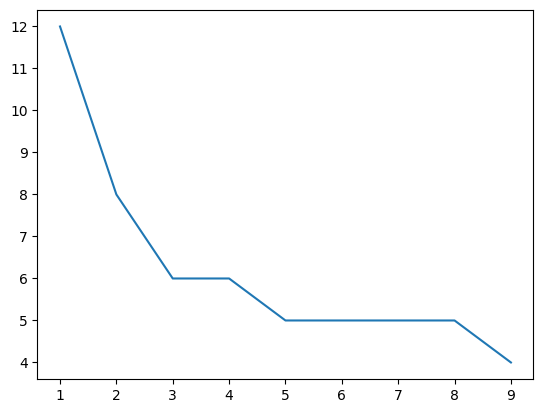

In [13]:
angle_arr = np.arange(1,10,1)
bands_arr = 15//angle_arr+4
plt.plot(angle_arr,bands_arr)